# Generating OCR Synthetic Data

We'd like to some synthetic OCR data. Plan is to:

1. Load a relevant text based dataset.
2. Generate the OCR data.
3. Test this on an OCR model.

In [4]:
# load the dataset
from datasets import load_dataset

dataset = load_dataset(
    "multi_eurlex",
    "all_languages",
    label_level="level_3",
    trust_remote_code=True,
)

dataset

DatasetDict({
    train: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 55000
    })
    test: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 5000
    })
})

Now to investigate how to synthesise the OCR data using the `trdg` module.

Missing modules for handwritten text generation.
Règlement (CE) no 1330/2003 de la Commission
du 25 juillet 2003
établissant les valeurs forfaitaires à l'importation pour la détermination du prix d'entrée de certains fruits et légumes
LA COMMISSION DES COMMUNAUTÉS EUROPÉENNES,
vu le traité instituant la Communauté européenne,
vu le règlement (CE) n° 3223/94 de la Commission du 21 décembre 1994 portant modalités d'application du régime à l'importation des fruits et légumes(1), modifié en dernier lieu par le règlement (CE) n° 1947/2002(2), et notamment son article 4, paragraphe 1,
considérant ce qui suit:
(1) Le règlement (CE) n° 3223/94 prévoit, en application des résultats des négociations commerciales multilatérales du cycle d'Uruguay, les critères pour la fixation par la Commission des valeurs forfaitaires à l'importation des pays tiers, pour les produits et les périodes qu'il précise dans son annexe.
(2) En application des critères susvisés, les valeurs forfaitaires à l'importation 

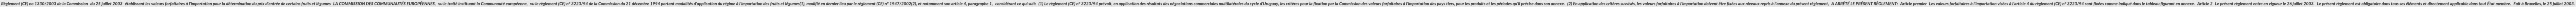

In [5]:
from trdg.generators import GeneratorFromStrings

examples = [dataset['train'][i]['text']['fr'] for i in range(1, 4)]
generator = GeneratorFromStrings(examples, language='fr', random_blur=False, random_skew=True, skewing_angle=0, blur=1)
image = next(generator)[0]
print(dataset['train'][1]['text']['fr'])
image

Ok, so this creates some text, but it's too long to really be useable by eye, lets do something smaller

test


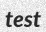

In [6]:
gen = GeneratorFromStrings(['test'])
out = next(gen)
print(out[1])
out[0]

Ok, that's more like it.

Let's grab an OCR model and try some inference to test this

In [7]:
# load the model
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten", clean_up_tokenization_space=False)
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# model.to(device)

/Users/edable-heath/Documents/ARC-SPICE/.venv-3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
pixel_values = processor(image, return_tensors='pt').pixel_values
pixel_values.to(device)
pixel_values

tensor([[[[0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          [0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          [0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          ...,
          [0.8431, 0.8353, 0.8275,  ..., 0.8353, 0.8431, 0.8431],
          [0.8431, 0.8353, 0.8275,  ..., 0.8353, 0.8431, 0.8431],
          [0.8431, 0.8353, 0.8275,  ..., 0.8353, 0.8431, 0.8431]],

         [[0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          [0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          [0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          ...,
          [0.8431, 0.8353, 0.8275,  ..., 0.8353, 0.8431, 0.8431],
          [0.8431, 0.8353, 0.8275,  ..., 0.8353, 0.8431, 0.8431],
          [0.8431, 0.8353, 0.8275,  ..., 0.8353, 0.8431, 0.8431]],

         [[0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          [0.8275, 0.8353, 0.8510,  ..., 0.8431, 0.8510, 0.8275],
          [0.8275, 0.8353, 0.8510,  ..., 0

In [9]:
generated_ids = model.generate(pixel_values, max_new_tokens=500)

In [10]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [11]:
generated_text

'Round123456789101112131415161718192021222324252627282930313233343536273839404243443546GroundHAHAHAAHAHAHAAHAHAHAAHAHAHAAHAHAHAAHAHAHAAHAHAHResultWDWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW D Draw L Losses played at the'

Ok, so this seems to work, lets write a generation script to create a dataset, first looking into further data manipulation in the image generation.

In [12]:
ocr_gen = GeneratorFromStrings(examples, language='fr', random_blur=True, random_skew=True, skewing_angle=0, blur=1)

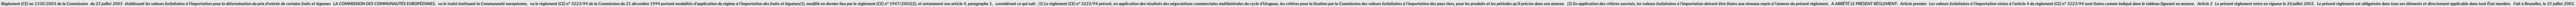

In [13]:
next(ocr_gen)[0]

This doesn't work super well. Let's split it up by sentence.

In [14]:
data_example = dataset['train'][0]['text']['fr']
data_example

"DÉCISION DE LA COMMISSION\ndu 6 mars 2006\nétablissant la classification des caractéristiques de réaction au feu de certains produits de construction pour ce qui concerne les sols en bois et les lambris et revêtements muraux extérieurs en bois massif\n[notifiée sous le numéro C(2006) 655]\n(Texte présentant de l'intérêt pour l'EEE)\n(2006/213/CE)\nLA COMMISSION DES COMMUNAUTÉS EUROPÉENNES,\nVu le traité instituant la Communauté européenne,\nVu la directive 89/106/CEE du Conseil du 21 décembre 1988 relative au rapprochement des dispositions législatives, réglementaires et administratives des États membres concernant les produits de construction (1), et notamment son article 20, paragraphe 2,\nConsidérant ce qui suit:\n(1)\nLa directive 89/106/CEE considère que, afin de tenir compte des différences de niveau de protection existant à l’échelon national, régional ou local, il peut être nécessaire, pour chaque exigence essentielle, d’établir des classes de performance des produits dans les

In [15]:
def split_inputs(text, split_key):
    split_rows = text.split(split_key)
    recovered_splits = [split for split in split_rows]
    return recovered_splits


sentences = split_inputs(data_example, '\n')
sentences

['DÉCISION DE LA COMMISSION',
 'du 6 mars 2006',
 'établissant la classification des caractéristiques de réaction au feu de certains produits de construction pour ce qui concerne les sols en bois et les lambris et revêtements muraux extérieurs en bois massif',
 '[notifiée sous le numéro C(2006) 655]',
 "(Texte présentant de l'intérêt pour l'EEE)",
 '(2006/213/CE)',
 'LA COMMISSION DES COMMUNAUTÉS EUROPÉENNES,',
 'Vu le traité instituant la Communauté européenne,',
 'Vu la directive 89/106/CEE du Conseil du 21 décembre 1988 relative au rapprochement des dispositions législatives, réglementaires et administratives des États membres concernant les produits de construction (1), et notamment son article 20, paragraphe 2,',
 'Considérant ce qui suit:',
 '(1)',
 'La directive 89/106/CEE considère que, afin de tenir compte des différences de niveau de protection existant à l’échelon national, régional ou local, il peut être nécessaire, pour chaque exigence essentielle, d’établir des classes de

In [16]:
new_text = []
for sentence in sentences:
    if len(sentence) < 200:
        new_text.append(sentence)
    else:
        splits = sentence.split(',')
        new_text.append(splits)

In [17]:
sentences

['DÉCISION DE LA COMMISSION',
 'du 6 mars 2006',
 'établissant la classification des caractéristiques de réaction au feu de certains produits de construction pour ce qui concerne les sols en bois et les lambris et revêtements muraux extérieurs en bois massif',
 '[notifiée sous le numéro C(2006) 655]',
 "(Texte présentant de l'intérêt pour l'EEE)",
 '(2006/213/CE)',
 'LA COMMISSION DES COMMUNAUTÉS EUROPÉENNES,',
 'Vu le traité instituant la Communauté européenne,',
 'Vu la directive 89/106/CEE du Conseil du 21 décembre 1988 relative au rapprochement des dispositions législatives, réglementaires et administratives des États membres concernant les produits de construction (1), et notamment son article 20, paragraphe 2,',
 'Considérant ce qui suit:',
 '(1)',
 'La directive 89/106/CEE considère que, afin de tenir compte des différences de niveau de protection existant à l’échelon national, régional ou local, il peut être nécessaire, pour chaque exigence essentielle, d’établir des classes de

In [103]:
generator = GeneratorFromStrings(sentences, language='fr', random_blur=False, random_skew=False, skewing_angle=0, blur=0)
# next(generator)[0]

In [104]:
def run_ocr(input):
    pixel_values = processor(input, return_tensors='pt').pixel_values
    pixel_values.to(device)
    generated_ids = model.generate(pixel_values, max_new_tokens=1000)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [102]:
run_ocr(next(generator)[0])

'Du Gimans 2006'

In [108]:
for example in generator:
    print(f'Target: {example[1]}')
    print(f'OCR: {run_ocr(example[0])}')

Target: (5)
OCR: 15 )
Target: Dans le cadre d’une solution harmonisée, la décision 2000/147/CE de la Commission du 8 février 2000 portant modalités d’application de la directive 89/106/CEE du Conseil en ce qui concerne la classification des caractéristiques de réaction au feu des produits de construction (3) a instauré un système de classes.
OCR: DonstableAmerican lomanists advisorICTEarlo Johnson in Belize2000 prior-madiate landscape defense SPORTS nuclear news conference warehouse labor advertisements demonstrate to small ingredients
Target: (6)
OCR: (
Target: Pour les sols en bois et les lambris et revêtements muraux extérieurs en bois massif, il est nécessaire d’utiliser la classification instaurée par la décision 2000/147/CE.
OCR: Four levels en bois et les lambis et revetements muraux excierieurs en bois massif, il estricesnaire d'utiliser la classification instance parladecision 200011AVICE
Target: (7)
OCR: 17 )
Target: Pour de nombreux produits et/ou matériaux de construction, 

KeyboardInterrupt: 